In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Load IMDb dataset from TensorFlow Datasets
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_data, test_data = dataset['train'], dataset['test']

print(info)


tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/plain_text/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Plain text
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_dir='C:\\Users\\USER\\tensorflow_datasets\\imdb_reviews\\plain_text\\1.0.0',
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=129.83 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(), dtype=string),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'test': <S

In [2]:
#Preprocess the text data
import re
import string
import nltk

# Ensure tokenizer data is present (download if missing)
for pkg in ("punkt", "punkt_tab"):
    try:
        nltk.data.find(f"tokenizers/{pkg}")
    except LookupError:
        nltk.download(pkg)

# Ensure nltk_data path includes custom folder (if you previously used one)
nltk.data.path.append(r"C:\Users\USER\nltk_data")

# Download required NLTK resources (no-op if already present)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Accept bytes/tensor/str inputs and decode safely
    if isinstance(text, (bytes, bytearray)):
        text = text.decode('utf-8', errors='ignore')
    elif hasattr(text, 'numpy'):
        # tf.Tensor
        text = text.numpy().decode('utf-8', errors='ignore')
    else:
        text = str(text)

    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Convert TensorFlow dataset to pandas DataFrame
import pandas as pd
train_texts, train_labels = [], []
for text, label in train_data:
    # decode TensorFlow string tensors safely
    if hasattr(text, 'numpy'):
        s = text.numpy().decode('utf-8', errors='ignore')
    else:
        s = text.decode('utf-8', errors='ignore') if isinstance(text, (bytes, bytearray)) else str(text)
    train_texts.append(s)
    train_labels.append(int(label.numpy()))

test_texts, test_labels = [], []
for text, label in test_data:
    if hasattr(text, 'numpy'):
        s = text.numpy().decode('utf-8', errors='ignore')
    else:
        s = text.decode('utf-8', errors='ignore') if isinstance(text, (bytes, bytearray)) else str(text)
    test_texts.append(s)
    test_labels.append(int(label.numpy()))

df_train = pd.DataFrame({'review': train_texts, 'label': train_labels})
df_test = pd.DataFrame({'review': test_texts, 'label': test_labels})

# Apply preprocessing
df_train['clean_review'] = df_train['review'].apply(preprocess_text)
df_test['clean_review'] = df_test['review'].apply(preprocess_text)
print(df_train.head())


[nltk_data] Downloading package punkt to C:\Users\USER/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER/nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to C:\Users\USER/nltk_data...


                                              review  label  \
0  This was an absolutely terrible movie. Don't b...      0   
1  I have been known to fall asleep during films,...      0   
2  Mann photographs the Alberta Rocky Mountains i...      0   
3  This is the kind of film for a snowy Sunday af...      1   
4  As others have mentioned, all the women that g...      1   

                                        clean_review  
0  absolutely terrible movie dont lured christoph...  
1  known fall asleep film usually due combination...  
2  mann photograph alberta rocky mountain superb ...  
3  kind film snowy sunday afternoon rest world go...  
4  others mentioned woman go nude film mostly abs...  


              precision    recall  f1-score   support

           0       0.88      0.88      0.88     12500
           1       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



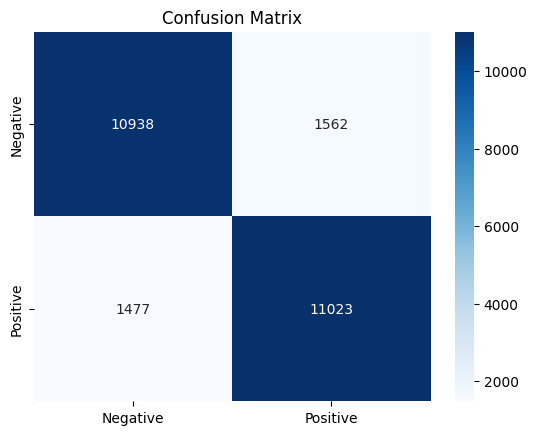

In [3]:
#TF-IDF Vectorization and Logistic Regression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(df_train['clean_review'])
X_test = vectorizer.transform(df_test['clean_review'])
y_train = df_train['label']
y_test = df_test['label']

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative','Positive'], yticklabels=['Negative','Positive'])
plt.title('Confusion Matrix')
plt.show()


In [4]:
#LTSM Model using TensorFlow/Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

max_words = 10000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_train['clean_review'])
X_train_seq = tokenizer.texts_to_sequences(df_train['clean_review'])
X_test_seq = tokenizer.texts_to_sequences(df_test['clean_review'])
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

model_lstm = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.fit(X_train_pad, y_train, epochs=3, batch_size=64, validation_split=0.2)

loss, acc = model_lstm.evaluate(X_test_pad, y_test)
print(f"LSTM Test Accuracy: {acc:.4f}")


Epoch 1/3


c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 269s 834ms/step - accuracy: 0.8036 - loss: 0.4269 - val_accuracy: 0.8662 - val_loss: 0.3312
Epoch 2/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 250s 798ms/step - accuracy: 0.8977 - loss: 0.2632 - val_accuracy: 0.8752 - val_loss: 0.3152
Epoch 3/3
313/313 ━━━━━━━━━━━━━━━━━━━━ 260s 832ms/step - accuracy: 0.9286 - loss: 0.1923 - val_accuracy: 0.8618 - val_loss: 0.3433
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 53ms/step - accuracy: 0.8557 - loss: 0.3619
LSTM Test Accuracy: 0.8557


In [5]:
#Word Cloud Visualization
from wordcloud import WordCloud

positive_text = ' '.join(df_train[df_train['label']==1]['clean_review'])
negative_text = ' '.join(df_train[df_train['label']==0]['clean_review'])

wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_neg = WordCloud(width=800, height=400, background_color='black').generate(negative_text)

wordcloud_pos.to_file('positive_wordcloud.png')
wordcloud_neg.to_file('negative_wordcloud.png')
